# Standard marxan output analysis 
### Based on the British Columbia example (Pacmara Tutorial)

Date: 26 Jan 2021  
Author: Tamara

## Requirements

In [1]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from IPython.display import display
#sns.set_theme(context="notebook",style="whitegrid", palette="rocket")

In [2]:
MARXAN_FOLDER = '/home/jovyan/work/datasets/raw/marxan_Tutorial/PracCONS7021/Marxan_backup'

In [3]:
## INPUT FILES used to RUN marxan
pu = pd.read_csv(f"{MARXAN_FOLDER}/input/pu.dat",sep=',')
spec = pd.read_csv(f"{MARXAN_FOLDER}/input/spec.dat", sep ='\t')
puvsp = pd.read_csv(f"{MARXAN_FOLDER}/input/puvsp.dat",sep='\t')
bound = pd.read_csv(f"{MARXAN_FOLDER}/input/bound.dat",sep='\t')
pu_area = gpd.read_file(f'{MARXAN_FOLDER}/pu/pulayer.shp')

<AxesSubplot:>

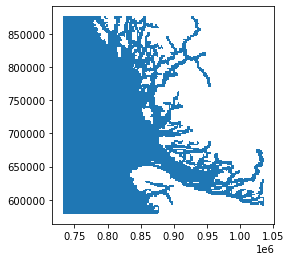

In [4]:
pu_area.plot()

### SCENARIO OUTPUTS

In [5]:
### OUTPUT FILES
best = pd.read_csv(f"{MARXAN_FOLDER}/output/output_best.csv")
freq = pd.read_csv(f"{MARXAN_FOLDER}/output/output_ssoln.csv")
summary = pd.read_csv(f"{MARXAN_FOLDER}/output/output_sum.csv")
best_mv = pd.read_csv(f"{MARXAN_FOLDER}/output/output_mvbest.csv")

### 1) Best solution/Indivdual solutions

<AxesSubplot:>

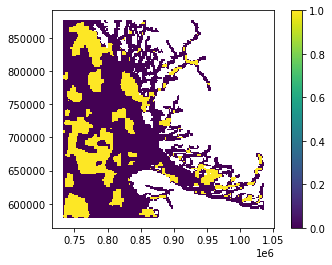

In [6]:
## Intersect best (or any individual solution) with PU grid
sol_grid = pu_area.merge(best,left_on='PUID',right_on = 'PUID',how='inner')
sol_grid.plot(column='SOLUTION', legend=True)

### 2) Frequency map

<AxesSubplot:>

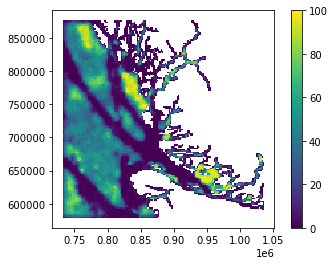

In [7]:
## Intersect with PU grid
freq_grid = pu_area.merge(freq,left_on='PUID',right_on = 'planning_unit',how='inner')
freq_grid.plot(column='number', legend=True)

<AxesSubplot:>

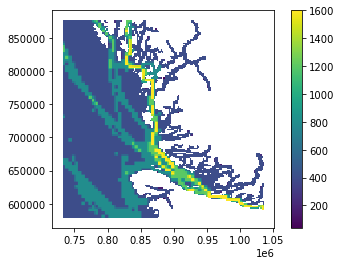

In [8]:
##Compare with cost surface
cost = pu_area.merge(pu,left_on='PUID',right_on = 'id',how='inner')
cost.plot(column='cost',legend=True)

### 3) 5 most different solutions

**Jaccard index in R:** Jaccrd index is [dissimilarity](https://stackoverflow.com/questions/35871157/the-difference-between-dist-functions-in-r)

**Jaccard index in python:** Jaccard resemblance matrix is default [(similarity)](https://stackoverflow.com/questions/35639571/python-pandas-distance-matrix-using-jaccard-similarity)

In [9]:
from scipy.cluster.hierarchy import linkage
from sklearn.cluster import AgglomerativeClustering
import pandas as pd

def ClusterSolutions(MARXAN_FOLDER,k=5):
    """
    Returns a list of the 5 most different solutions
    """
    
    # Open solutions matrix file
    solmat = pd.read_csv(f"{MARXAN_FOLDER}/output/output_solutionsmatrix.csv")
    solmat = solmat.loc[:,solmat.columns != 'SolutionsMatrix']
    
    # Create distance matrix with Jaccard similarity
    dist_mat = linkage(solmat, method='average',metric='jaccard')
    
    # Find k clusters
    cluster = AgglomerativeClustering(n_clusters=k, affinity='jaccard', linkage='average')  
#     see dendrogram
#     dend = shc.dendrogram(clust) 
    print(f'Building cluster of {k} most different solutions')
    groups = cluster.fit_predict(dist_mat)
    
    # Get best solution per cluster (solution with the lowest Score) from sum table
    summary = pd.read_csv(f"{MARXAN_FOLDER}/output/output_sum.csv")
    best =summary.loc[summary.loc[:]['Score'].idxmin(),'Run_Number']
    print(f'Overall best solution is {best}')
    
    bestlist =[]
    for i in range(k):
        g = np.where(groups == i)[0]
        sol = summary.loc[summary.loc[g]['Score'].idxmin(),'Run_Number']
        print(f'Group {i+1} best solution = {sol}')
        bestlist.append(sol)

#     See figure
#     plt.figure(figsize=(10, 7))
#     plt.scatter(clust[:,0], clust[:,1], c=cluster.labels_, cmap='rainbow')
    
    return bestlist
    

In [10]:
bestsols= ClusterSolutions(MARXAN_FOLDER,k=5)

Building cluster of 5 most different solutions
Overall best solution is 29
Group 1 best solution = 29
Group 2 best solution = 99
Group 3 best solution = 98
Group 4 best solution = 97
Group 5 best solution = 96


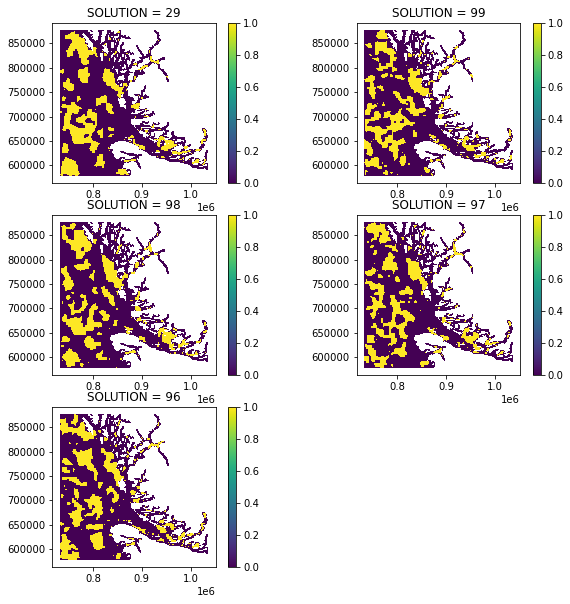

In [11]:
#fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
fig = plt.figure(figsize=(10,10))

for idx, sol in enumerate(bestsols):
    axn = fig.add_subplot(321+idx)
    solution = pd.read_csv(f"{MARXAN_FOLDER}/output/output_r000{sol}.csv")
    solution_grid = pu_area.merge(solution,left_on='PUID',right_on = 'PUID',how='inner')
    solution_grid.plot(ax=axn,column='SOLUTION', legend=True)
    axn.set_title(f'SOLUTION = {sol}')

#### Summary info 5 most different solutions

In [17]:
summary = pd.read_csv(f"{MARXAN_FOLDER}/output/output_sum.csv")

In [18]:
sum_diff =summary[summary['Run_Number'].isin(bestsols)]

### 4) GAP Analysis

In [30]:
def plotGap(data, title, ax, plt, post_marxan):
    width = 6
    labels = data.name
    x_pos = [i for i, _ in enumerate(labels)]
    propi = data.prop_lock
    target = data.prop
    if post_marxan:
        propf = data["prop_best_lock"]
        ax.barh(labels,propf, width, left=propi,
            label='post-marxan',color='#00cccc', edgecolor='#00cccc', align='center')
    ax.barh( labels, propi, width, label='pre-marxan',color='#617f9d', edgecolor='#617f9d', align='center')
    
    ax.plot(target,labels,color='red')
    
    ax.set_xlabel('Percentage protected')
    ax.set_ylabel('Species')
    ax.set_title(title)
    ax.legend(loc ='upper left')
    plt.xlim([0, 1])
    plt.yticks(  x_pos, labels)

In [31]:
def GapAnalysis(MARXAN_FOLDER,
                pu_df,
                spec_df,
                puvsp_df,
                best,
                pre_marxan=True, 
                post_marxan=True):
    
    """This function analyses the protected amount of each species
    and returns a plot and a list of targets that have not been met
    """
    
    ## Unify targets and proportions in one file
    #1. Total species amount
    total = puvsp.groupby(['species']).sum('amount').reset_index()
    spec_amount=spec.merge(total[['species','amount']], 
                       left_on = 'id', 
                       right_on = 'species', 
                       how='inner').drop(columns=['species']).rename(columns={'amount':'amount_total'})
    #Add to table
    spec_amount['amount_target']=spec_amount['amount_total']*spec_amount['prop']
    
    
    #2. locked-in species amount
    # Get PUID that have been locked-in (2)
    pulock = pu[pu['status']==2].id
    lockin = puvsp[puvsp.pu.isin(pulock)].groupby(['species']).sum('amount').reset_index()
    spec_amount = spec_amount.merge(lockin[['species','amount']], 
                                left_on = 'id', 
                                right_on = 'species', 
                                how='left').drop(columns=['species']).rename(columns={'amount':'amount_lock'})

    # fill NaN with 0
    spec_amount = spec_amount.fillna(0)
    #Add to table 
    spec_amount['prop_lock']=(spec_amount['amount_lock']/spec_amount['amount_total'])
    
    plt.style.use('fast')
    fig, anx = plt.subplots(nrows=1, ncols=2,figsize=(10,15), constrained_layout=True)
    plotGap(spec_amount, 'Gap Analysis Pre-Marxan (Area inside Protected Areas)',anx[0], plt, post_marxan=False)
    
    if post_marxan:
        
    #4. Best solution species amount
        # Get PUID that have been selected
        pubest = best[best['SOLUTION']==1].PUID
        final= puvsp[puvsp.pu.isin(pubest)].groupby(['species']).sum('amount').reset_index()
        spec_amount = spec_amount.merge(final[['species','amount']], 
                                left_on = 'id', 
                                right_on = 'species', 
                                how='inner').drop(columns=['species']).rename(columns={'amount':'amount_best'})

        #Add to table
        spec_amount['prop_best']=(spec_amount['amount_best']/spec_amount['amount_total'])
        
    #5. Best solution - locked species amount
        spec_amount['prop_best_lock']=(spec_amount['prop_best']-spec_amount['prop_lock'])
        # display(spec_amount.head())
        melt_spenc_amount = spec_amount.melt(id_vars=['name','prop'], var_name='cols', value_vars=['prop_lock', 'prop_best_lock'], value_name='vals')
        # display(melt_spenc_amount)
        
    #6. ### PLOT Post-Marxan Gap Analysis 
        ### 3.PLOT Pre-Marxan Gap Anlysis
        plotGap(spec_amount, 'Gap Analysis Post-Marxan (Area inside Protected Areas + Best Solution)', anx[1], plt, post_marxan=True)
    
    return plt.show()
        

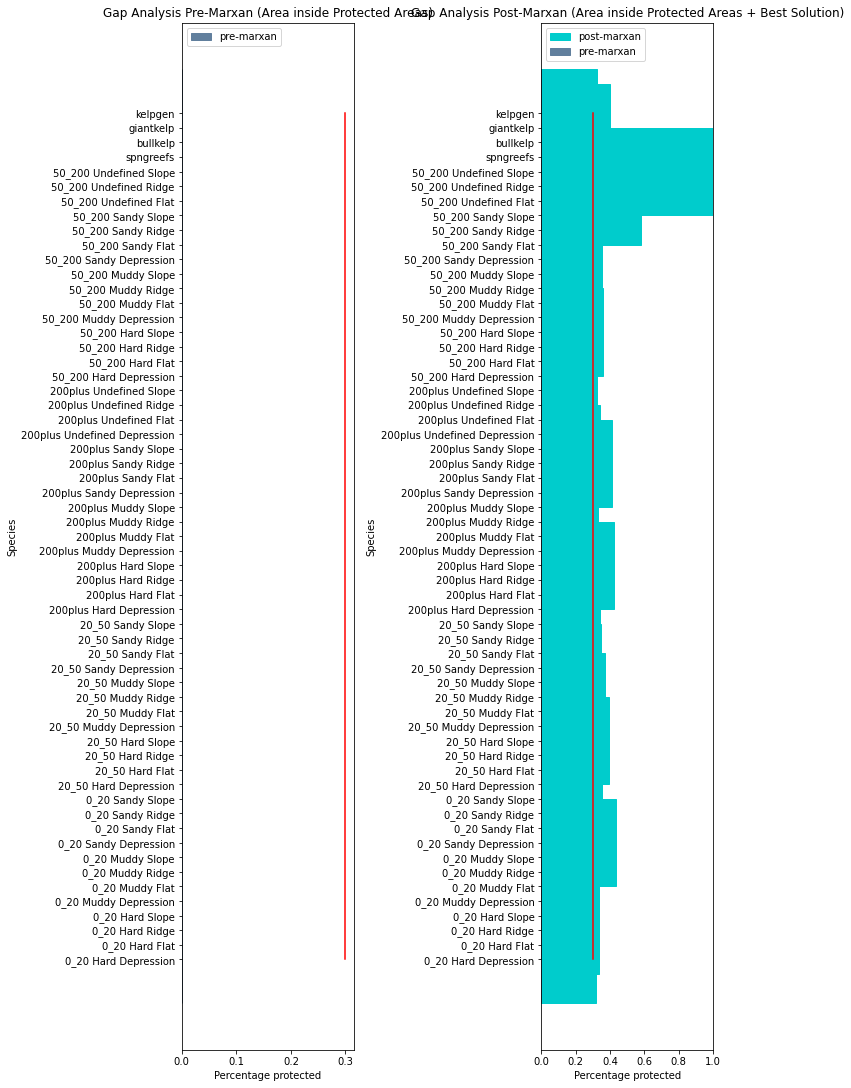

In [32]:
MARXAN_FOLDER = '/home/jovyan/work/datasets/raw/marxan_Tutorial/PracCONS7021/Marxan_backup'
### Read in relevant files:
## Lock-in Protected areas --> from pu.dat file
pu = pd.read_csv(f"{MARXAN_FOLDER}/input/pu.dat",sep=',')
## Targets --> from spe.dat
spec = pd.read_csv(f"{MARXAN_FOLDER}/input/spec.dat", sep =',')
## Area covered initially --> puvsp
puvsp = pd.read_csv(f"{MARXAN_FOLDER}/input/puvsp.dat",sep=',')
## Output best
best = pd.read_csv(f"{MARXAN_FOLDER}/output/output_best.csv")

GapAnalysis(MARXAN_FOLDER, 
            pu_df = pu,
            spec_df =spec,
            puvsp_df=puvsp,
            best = best) # No locked in pus

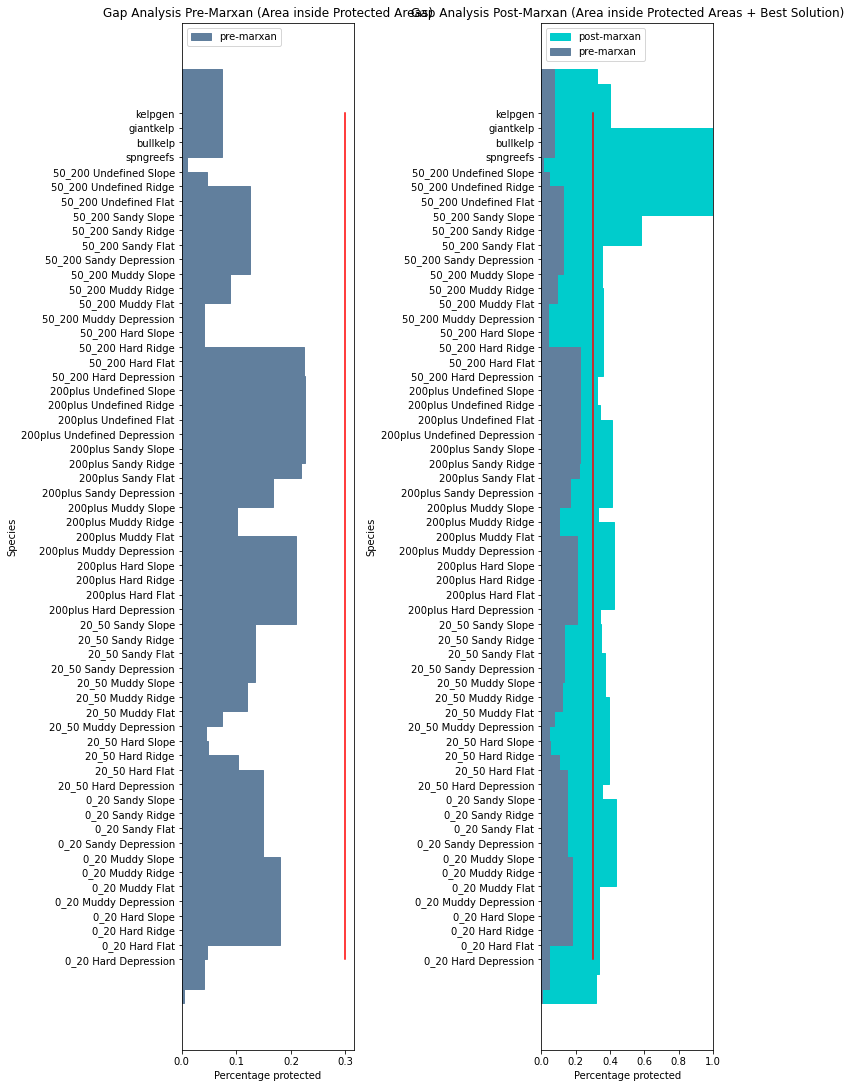

In [34]:
### Simulate some locked-in pus
import random

randomlist = []
for i in range(0,int(0.15*len(pu))):
    n = random.randrange(0,3,1)
    randomlist.append(n)

l = [0] * (len(pu) - len(randomlist))
randomlist.extend(l)
len(randomlist)

pumock = pu
pumock['status'] = randomlist

GapAnalysis(MARXAN_FOLDER, 
            pu_df = pumock,
            spec_df =spec,
            puvsp_df=puvsp,
            best = best)

**Status Meaning**\
**0** The PU is not guaranteed to be in the initial (or seed) reserve system, however, it still may be. Its chance of being included in the initial reserve system is determined by the ‘starting proportion’ specified in the Input Parameter File (see Section 3.2.1).\
**1** The PU will be included in the initial reserve system but may or may not be in the final solution.\
**2** The PU is fixed in the reserve system (“locked in”). It starts in the initial reserve system and cannot be removed.\
**3** The PU is fixed outside the reserve system (“locked out”). It is not included in the initial reserve system and cannot be added.

### 5) Scheduled planning